In [1]:
import pandas as pd

# Read the Parquet file
df_pos = pd.read_parquet('positive_sent_articles.parquet')
df_neg = pd.read_parquet('negative_sent_articles.parquet')

In [2]:
len(df_pos)
len(df_neg)

70401

In [3]:
df_pos.head()

,year_month,title,clean_text,prob_pos,date,year
0,2020-01,"\r \tInsilico, Pfizer to jointly explore novel...","Insilico, Pfizer to jointly explore novel data...",0.722864,2020-01-01,2020
1,2020-01,\r \tIsraeli data science platform co Iguazio ...,Israeli data science platform for real time ma...,0.794515,2020-01-01,2020
2,2020-01,\r \tStudy demonstrates accuracy of AI system ...,Study demonstrates accuracy of AI system in di...,0.527837,2020-01-01,2020
3,2020-01,\r \r \r Blow Molding: Online ...,Blow Molding: Online PET Preform Inspection Us...,0.642190,2020-01-01,2020
4,2020-01,\r Irish AI firm announces new collabo...,Registered in Ireland: . Everseen’s retail tec...,0.579075,2020-01-01,2020


In [4]:
df_neg.head()

,year_month,title,clean_text,prob_neg
0,2020-01,\r \t\t\tGoogle CEO calls for regulation of ar...,“There is no question in my mind that artifici...,0.989812
1,2020-01,\r \tCould AI beat humans in spotting breast t...,Could AI beat humans in spotting breast tumour...,0.999377
2,2020-01,\r \tIsrael Innovation Authority to help train...,"""In recent years, data science is taking over ...",0.999929
3,2020-01,\r \tNew AI system determines aggressiveness o...,New AI system determines aggressiveness of pro...,0.904190
4,2020-01,\r \tNew Mexico Community College Launching 10...,New Mexico Community College Launching -week D...,0.902643


In [5]:
df_pos['date'] = pd.to_datetime(df_pos['date'])
df_pos['year'] = df_pos['date'].dt.year
df_pos['month']= df_pos['date'].dt.month

df_neg['date'] = pd.to_datetime(df_neg['year_month'])
df_neg['year'] = df_neg['date'].dt.year
df_neg['month']= df_neg['date'].dt.month

df_pos['sentiment_score'] = df_pos['prob_pos'] 
df_neg['sentiment_score'] = df_neg['prob_neg'] 

In [6]:
def extract_entities_title(text):
    doc = nlp(str(text))
    org_entities = []
    for ent in doc.ents:
        if ent.label_ in ["ORG","PERSON"]:
            org_entities.append(ent.text)
    return org_entities

def extract_entities_text(text):
    doc = nlp(str(text).lower())
    org_entities = []
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG", "LOC"]:
            org_entities.append(ent.text)
    return org_entities

def extract_entity_pairs(entities):
    pairs = []
    for i, ent1 in enumerate(entities):
        for j in range(i+1, len(entities)):
            ent2 = entities[j]
            if ent1 != ent2:
                pairs.append((ent1, ent2))
    return pairs

In [7]:
%%time
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=90)

INFO: Pandarallel will run on 90 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 33.1 ms, sys: 4.84 ms, total: 38 ms
Wall time: 37.6 ms


In [8]:
import spacy
#!python -m spacy download en_core_web_sm
#!pip install en_core_web_sm
nlp = spacy.load("en_core_web_sm")

2023-05-26 00:17:13.177122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 00:17:16.101839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-26 00:17:16.101969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [9]:
%%time
df_pos["ent_text"] = df_pos["clean_text"].parallel_apply(extract_entities_text)

CPU times: user 1.05 s, sys: 4.83 s, total: 5.88 s
Wall time: 4min 19s


In [10]:
%%time
df_neg["ent_text"] = df_neg["clean_text"].parallel_apply(extract_entities_text)

CPU times: user 1.64 s, sys: 6.54 s, total: 8.18 s
Wall time: 3min 51s


In [11]:
from collections import Counter
top_entities_pos = [entity for entities in df_pos["ent_text"] for entity in entities]
Counter(top_entities_pos).most_common(15)

[('microsoft', 19651),
 ('google', 15940),
 ('ibm', 15543),
 ('media group, inc.', 15510),
 ('europe', 14772),
 ('north america', 12369),
 ('intel', 7886),
 ('africa', 5531),
 (', inc.', 3820),
 ('asia pacific', 3426),
 ('dr.', 3376),
 ('quantum', 3273),
 ('middle east', 3154),
 ('sony', 3135),
 ('nvidia', 3059)]

In [12]:
top_entities_neg = [entity for entities in df_neg["ent_text"] for entity in entities]
Counter(top_entities_neg).most_common(15)

[('microsoft', 45112),
 ('google', 44470),
 ('ibm', 10560),
 ('europe', 9772),
 ('media group, inc.', 6908),
 ('npr', 6019),
 ('intel', 5511),
 ('north america', 5081),
 ('fcc', 5076),
 ('gpt', 4722),
 ('pichai', 3652),
 ('africa', 3542),
 ('cnn', 3425),
 ('nvidia', 3248),
 ('fda', 3175)]

In [13]:
df_pos["ent_text"] = list(df_pos["ent_text"])
df_neg["ent_text"] = list(df_neg["ent_text"])

In [14]:
import matplotlib.pyplot as plt

N = 10

# Get the top N entities from the title
entities = [entity for entities in df_pos["ent_text"] for entity in entities]
top_entities_pos = [entity for entity, count in Counter(entities).most_common(N)]

# Create a new DataFrame with only the rows containing the top entity
rows_with_top_entities_pos = df_pos[df_pos["ent_text"].parallel_apply(lambda x: any(entity in top_entities_pos for entity in x))]
df_top_entities_pos = pd.DataFrame(rows_with_top_entities_pos)

In [15]:
# Group the DataFrame by date and entity, and compute the mean sentiment score
grouped_pos = df_top_entities_pos.explode("ent_text").groupby(["date", "ent_text"])["sentiment_score"].mean().reset_index()

# Print the total number of unique entity groups
Counter(grouped_pos['ent_text']).most_common(10)

[(', inc.', 40),
 ('africa', 40),
 ('amazon', 40),
 ('apple', 40),
 ('asia', 40),
 ('asia pacific', 40),
 ('asia-pacific', 40),
 ('cbs', 40),
 ('dr.', 40),
 ('europe', 40)]

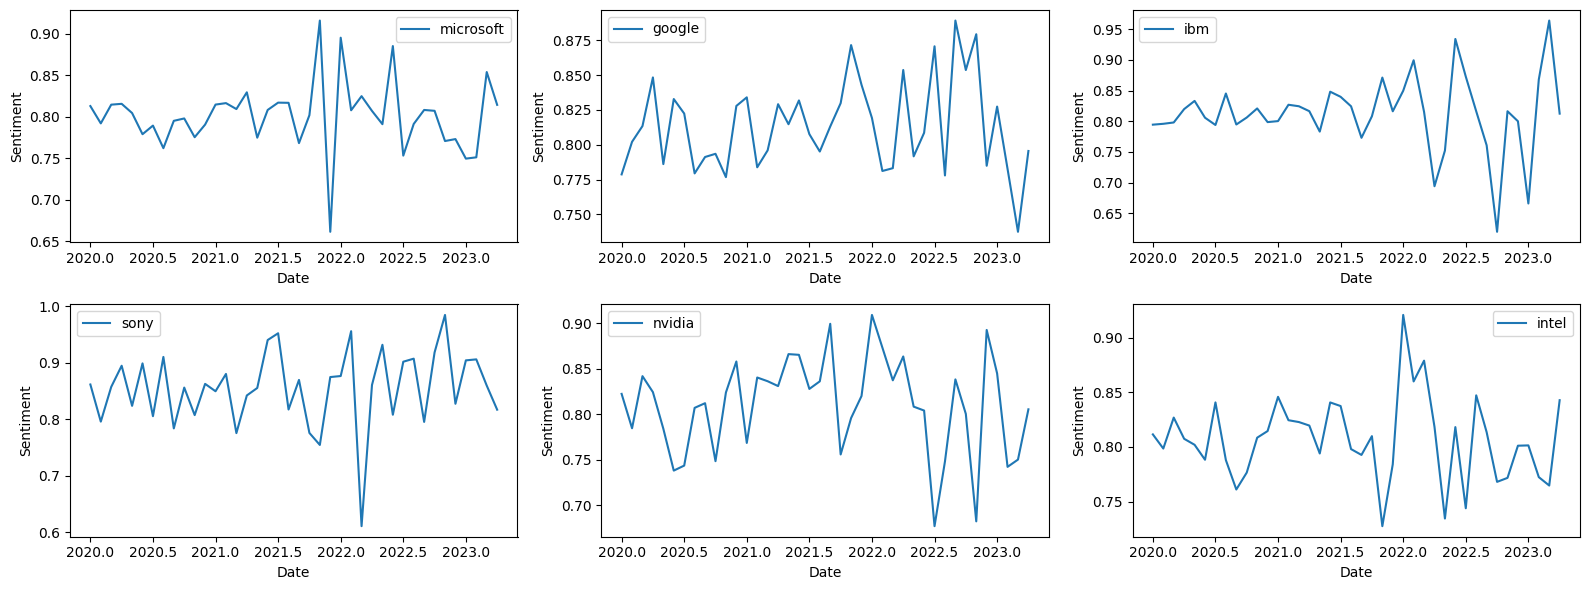

In [36]:
#df_pos['year'] = pd.DatetimeIndex(df_pos['date']).year
#df_pos['month'] = pd.DatetimeIndex(df_pos['date']).month

df_exploded_pos = df_pos.reset_index().explode('ent_text')



search_list_pos = ['microsoft', 'google', 'ibm', 'sony', 'nvidia', 'intel']
# filter for rows with elements of interest
df_filtered_pos = df_exploded_pos[df_exploded_pos['ent_text'].isin(search_list_pos)]
df_filtered_pos = df_filtered_pos.reset_index(drop=True)

# group by date and element of interest, and calculate mean sentiment
grouped_pos = df_filtered_pos.groupby(['year','month', 'ent_text'])['sentiment_score'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))

for i, elem in enumerate(search_list_pos):
    row = i // 3
    col = i % 3
    data = grouped_pos[grouped_pos['ent_text'] == elem]
    axes[row, col].plot(data['year'] + (data['month']-1)/12, data['sentiment_score'], label=elem)
    axes[row, col].legend()
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Sentiment')
    #axes[row, col].set_ylim(0.8,0.1)
    #axes[row, col].axhline(y=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

In [17]:
entities = [entity for entities in df_neg["ent_text"] for entity in entities]
top_entities_neg = [entity for entity, count in Counter(entities).most_common(N)]
rows_with_top_entities_neg = df_neg[df_neg["ent_text"].parallel_apply(lambda x: any(entity in top_entities_neg for entity in x))]
df_top_entities_neg = pd.DataFrame(rows_with_top_entities_neg)
grouped_neg = df_top_entities_neg.explode("ent_text").groupby(["date", "ent_text"])["sentiment_score"].mean().reset_index()

# Print the total number of unique entity groups
Counter(grouped_neg['ent_text']).most_common(10)

[(', inc.', 40),
 ('africa', 40),
 ('alphabet', 40),
 ('alphabet inc.', 40),
 ('amazon', 40),
 ('apple', 40),
 ('asia', 40),
 ('asia pacific', 40),
 ('asia-pacific', 40),
 ('at&t', 40)]

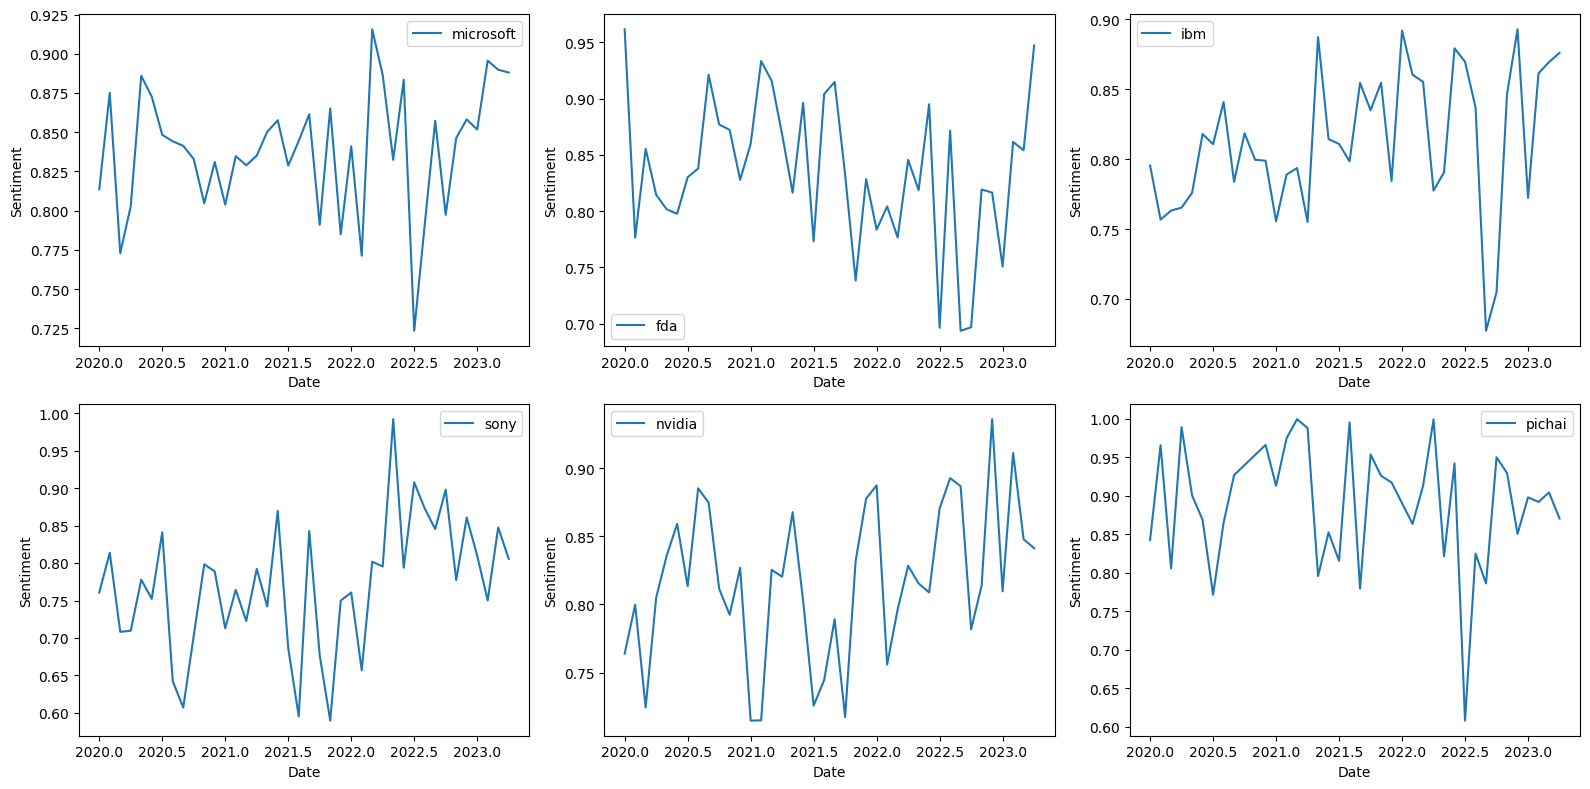

In [37]:
df_exploded_neg = df_neg.reset_index().explode('ent_text')



search_list_neg = ['microsoft', 'fda', 'ibm', 'sony', 'nvidia', 'pichai']
# filter for rows with elements of interest
df_filtered_neg = df_exploded_neg[df_exploded_neg['ent_text'].isin(search_list_neg)]
df_filtered_neg = df_filtered_neg.reset_index(drop=True)

# group by date and element of interest, and calculate mean sentiment
grouped_neg = df_filtered_neg.groupby(['year','month', 'ent_text'])['sentiment_score'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

for i, elem in enumerate(search_list_neg):
    row = i // 3
    col = i % 3
    data = grouped_neg[grouped_neg['ent_text'] == elem]
    axes[row, col].plot(data['year'] + (data['month']-1)/12, data['sentiment_score'], label=elem)
    axes[row, col].legend()
    axes[row, col].set_xlabel('Date')
    axes[row, col].set_ylabel('Sentiment')
    #axes[row, col].set_ylim(0.8,0.1)
    #axes[row, col].axhline(y=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

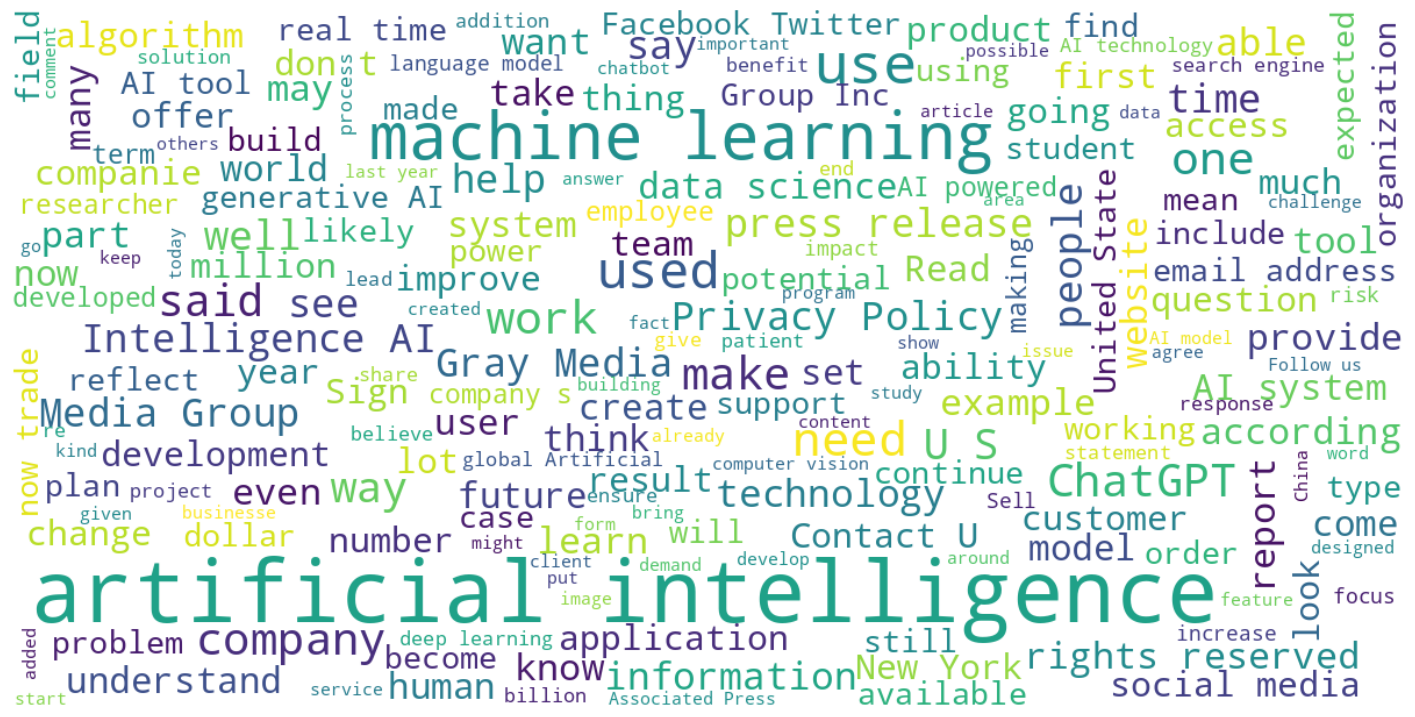

In [19]:
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
neg_text_corpus = ' '.join(df_neg['clean_text'].values)
neg_wordcloud = WordCloud(width=1200, height=600, background_color='white', max_words=200).generate(neg_text_corpus)
plt.figure(figsize=(18, 10))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

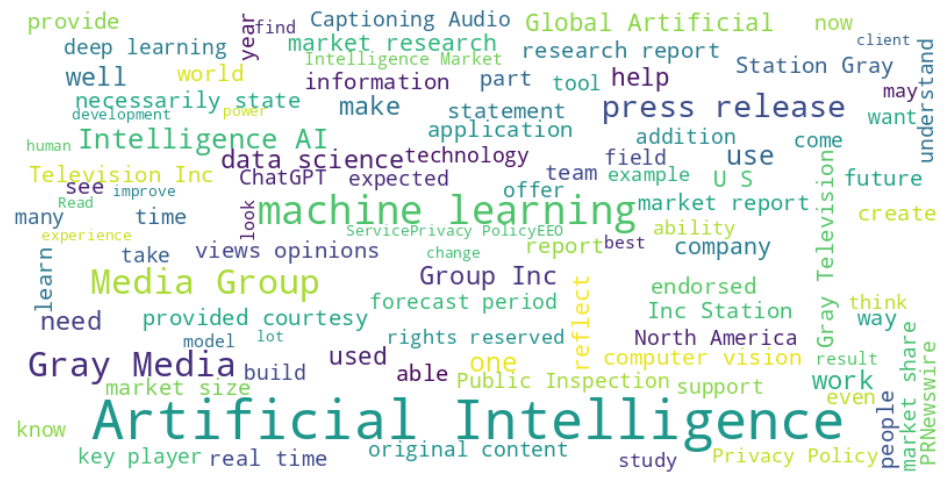

In [20]:
pos_text_corpus = ' '.join(df_pos['clean_text'].values)
pos_wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(pos_text_corpus)
plt.figure(figsize=(12, 8))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()